# Markov Chain Monte Carlo (MCMC)

## Why Sampling ?

Lets start with why we need sampling. Sampling data from a distribution helps use make sense of the parameters defined in that space. Maybe provide a numerical value to some of them with a probability. 

Lets take an example of defining $\pi$ using sampling from a uniform distrbution. We will generate around 5000 samples from a uniform distribution and then match is against the area of of the circle equation. If we start from $(0,0)$, samples are considered positive if within the circle. So the equation becomes,
$$
f(x,y) = \mathbb{I}(x^2 + y^2 \leq r^2)
$$


In [1]:
import torch
pi_n_samples = 5000
radius = torch.tensor([2.0])
uniform_distribution = torch.distributions.Uniform(low=radius.negative(),high=radius)
samples_x_y = uniform_distribution.sample(sample_shape=(pi_n_samples,2))
samples_within_circle_area = torch.where(samples_x_y.square().sum(dim=1)<=radius.square(),
                                         torch.tensor(True), torch.tensor(False))
# area formed by valid samples is the area of the circle (total_area = 4r^2)
extracted_valid_samples = 4 * radius.square() * samples_within_circle_area 
estimated_pi = extracted_valid_samples.mean()/radius.square()
print('Estimated pi : ',estimated_pi.item())
print('Actual pi :', torch.pi)


Estimated pi :  3.138400077819824
Actual pi : 3.141592653589793


## MCMC



In [7]:
from typing import Callable, NamedTuple
import torch
import torch.jit as jit  
import arviz as az

# theta
class Position(NamedTuple):
    a: torch.Tensor
    b: torch.Tensor
    logits: torch.Tensor

class EnergyParameters:
    #potential
    position: Position
    potential_energy: torch.Tensor
    potential_energy_grad: torch.Tensor
    #kinetic
    velocity: torch.Tensor
    kinetic_energy: torch.Tensor

    def __init__(self, potential_energy_fn:Callable):
        self.potential_energy_fn = potential_energy_fn
    
    def set_parameters(self, position:Position):
        self.position = position
        self.potential_energy = self.potential_energy_fn(position)
        self.potential_energy_grad = torch.func.grad(self.potential_energy_fn)(position)
        self.velocity, self.precision, self.covariance = self.generate_default_velocity(position)
        self.kinetic_energy = self.kinetic_energy_fn(self.velocity)
    
    def set_velocity(self, velocity:torch.Tensor):
        self.velocity = velocity
        self.kinetic_energy = self.kinetic_energy_fn(self.velocity)
    
    def generate_default_velocity(self, position:Position):
        precision, covariance = self.generate_inverse_mass_matrix_and_sigma(self.covariance_shape_from_position(position))
        return self.generate_random_gaussian(covariance), precision, covariance

    def generate_random_gaussian(self, covariance: torch.Tensor):
        return torch.distributions.MultivariateNormal(loc=torch.zeros(covariance.shape[-1]),covariance_matrix=covariance).sample()

    def covariance_shape_from_position(self, position:Position):
        covariance_shape = 0
        for value in position:
            covariance_shape += value.unsqueeze(0).shape[-1]
        return covariance_shape

    def generate_inverse_mass_matrix_and_sigma(self, covariance_shape: int):
        covariance = torch.eye(covariance_shape)
        inverse_mass_matrix = covariance.inverse()
        return inverse_mass_matrix, covariance

    def kinetic_energy_fn(self, velocity:torch.Tensor):
        return 0.5*torch.matmul(velocity, torch.matmul(self.precision, velocity.T))

def ravel_fn(value: Position):
        return torch.cat([current_tensor.ravel() for current_tensor in value])

def unravel_fn(values: torch.Tensor, structured_tuple:Position):
    shapes = []
    output = {}
    for struct_val in structured_tuple:
        shapes.append(struct_val.unsqueeze(0).shape[-1])
    split_tensors = torch.split(values,shapes)
    for i,name in enumerate(structured_tuple._fields):
        # if else removes inner dimensions of single tensor
        output[name] = split_tensors[i] if split_tensors[i].shape[-1] != 1 else split_tensors[i][0]
    return Position(**output)

class HMCAlgorithm : 

    def __init__(self, log_density_fn: Callable, step_size=0.01, l=1, n_chains=4, use_kinetic_grad=False):
        self.log_density_fn = log_density_fn
        self.step_size = step_size
        self.l = l
        self.energy_parameters = EnergyParameters(log_density_fn)
        self.proposal_accepted_count = [0]*n_chains
        self.use_kinetic_grad = use_kinetic_grad

    def updated_position(self, position:Position, step_size:float, inverse_mass_matrix:torch.Tensor, velocity:torch.Tensor):
        # print(position)
        markov_chain = torch.cat([value.ravel() for value in position])
        # torch.matmul(inverse_mass_matrix,velocity) is the kinetic gradient
        if self.use_kinetic_grad:
            result = markov_chain + step_size*torch.func.grad(self.energy_parameters.kinetic_energy_fn)(velocity)
        else:
            result = markov_chain + step_size*torch.matmul(inverse_mass_matrix,velocity)
        return unravel_fn(result, position)

    def updated_velocity(self, velocity:torch.Tensor, step_size:float, next_potential_energy_grad:torch.Tensor, is_half_step_momentum = False):
        return torch.subtract(velocity,step_size*(0.5 if is_half_step_momentum else 1)*next_potential_energy_grad)
    
    def update(self, position: Position, chain_index: int, iteration_no: int):
        delta_energy, proposal_position = self.step_integrator(position)
        # nan fix
        delta_energy = torch.where(torch.isnan(delta_energy), -torch.inf, delta_energy)
        # MH Algo
        alpha = torch.min(torch.exp(delta_energy), torch.ones(1))
        # print(f'Delta energy : {delta_energy}, {total_prev_energy}, {total_proposal_energy}, {alpha}')
        accept_condition = torch.distributions.Bernoulli(alpha).sample()
        print(f'Delta energy : {delta_energy}, {alpha}, {proposal_position.a}, {proposal_position.b}, {self.proposal_accepted_count[chain_index]}')
        result_proposal = position
        if accept_condition.bool():
            self.proposal_accepted_count[chain_index] += 1
            result_proposal = proposal_position
    
        acceptance_ratio = self.proposal_accepted_count[chain_index]/iteration_no
        return result_proposal, acceptance_ratio
  
    def step_integrator(self, position:Position):
        self.energy_parameters.set_parameters(position)
        prev_potential_energy = self.energy_parameters.potential_energy
        prev_kinetic_energy = self.energy_parameters.kinetic_energy
        prev_velocity = self.energy_parameters.velocity
        prev_potential_energy_grad = self.energy_parameters.potential_energy_grad

        prev_half_velocity = torch.subtract(prev_velocity,
                                             self.step_size*0.5*ravel_fn(prev_potential_energy_grad))
        # print('prev_half_velocity',prev_half_velocity)
        self.energy_parameters.set_velocity(prev_half_velocity)

        # l_frog_steps
        next_position, next_velocity = self.l_frog_steps(prev_half_velocity, position, self.energy_parameters.precision)
        
        full_step_position = self.updated_position(position=next_position, step_size=self.step_size,
                                                   inverse_mass_matrix=self.energy_parameters.precision, velocity=next_velocity)
        # print('full_step_position',full_step_position)
        self.energy_parameters.set_parameters(full_step_position)
        half_step_potential_energy_grad = self.energy_parameters.potential_energy_grad
        # print('half_step_potential_energy_grad',half_step_potential_energy_grad)

        half_step_velocity = self.updated_velocity(velocity=next_velocity,step_size=self.step_size,
                                                   next_potential_energy_grad=ravel_fn(half_step_potential_energy_grad),is_half_step_momentum=True)
        # print('half_step_velocity',half_step_velocity)
        self.energy_parameters.set_velocity(half_step_velocity)

        total_proposal_energy = -self.energy_parameters.potential_energy - self.energy_parameters.kinetic_energy
        total_prev_energy = -prev_potential_energy - prev_kinetic_energy
        return total_prev_energy - total_proposal_energy, full_step_position

    def l_frog_steps(self, prev_half_velocity, prev_position, precision):
        for _ in range(self.l):
            # print(prev_position)
            next_position = self.updated_position(position=prev_position, step_size=self.step_size,
                                                  inverse_mass_matrix=precision, velocity=prev_half_velocity)
            # print('next_position',next_position)

            self.energy_parameters.set_parameters(next_position)
            next_potential_energy_grad = self.energy_parameters.potential_energy_grad
            # print('next_potential_energy_grad',next_potential_energy_grad)

            next_velocity = self.updated_velocity(prev_half_velocity, step_size=self.step_size, next_potential_energy_grad=ravel_fn(next_potential_energy_grad))
            # print('next_velocity',next_velocity)
            self.energy_parameters.set_velocity(next_velocity)
            prev_half_velocity = next_velocity
            prev_position = next_position
        return next_position,next_velocity
    

In [12]:
n_of_positives = torch.tensor( [ 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 5, 2, 5, 3, 2, 7, 7, 3, 3, 2, 9, 10, 4, 4, 4, 4, 4, 4, 4, 10, 4, 4, 4, 5, 11, 12, 5, 5, 6, 5, 6, 6, 6, 6, 16, 15, 15, 9, 4, ], dtype=torch.float32)
group_size = torch.tensor( [ 20, 20, 20, 20, 20, 20, 20, 19, 19, 19, 19, 18, 18, 17, 20, 20, 20, 20, 19, 19, 18, 18, 25, 24, 23, 20, 20, 20, 20, 20, 20, 10, 49, 19, 46, 27, 17, 49, 47, 20, 20, 13, 48, 50, 20, 20, 20, 20, 20, 20, 20, 48, 19, 19, 19, 22, 46, 49, 20, 20, 23, 19, 22, 20, 20, 20, 52, 46, 47, 24, 14, ], dtype=torch.float32)
n_rat_tumors = len(group_size)

# rng_key = jax.random.PRNGKey(82)
# tfd = tfp.distributions
n_rat_tumors = 71

jacobian_fn = torch.func.jacfwd(torch.nn.functional.sigmoid)
jacobian_fn_softplus = torch.func.jacfwd(torch.nn.functional.softplus)

def joint_log_prob(params: Position) -> torch.Tensor:
    a, b, logits = params.a, params.b, params.logits

    thetas = torch.nn.functional.sigmoid(logits)
    a = torch.nn.functional.softplus(a)
    b = torch.nn.functional.softplus(b)
    log_det_jacob = torch.sum(
        torch.vmap(lambda logit: torch.log(torch.abs(torch.linalg.det(jacobian_fn(logit.reshape(1, 1))))))(logits)
    )
    # improper prior for a,b
    logprob_ab = torch.log(torch.float_power(a + b, -2.5))

    # logprob prior of theta
    logprob_thetas = torch.distributions.beta.Beta(a, b).log_prob(thetas).sum()

    apply_data =  torch.vmap(lambda y, N, theta: torch.distributions.binomial.Binomial(N, probs=theta, validate_args=False).log_prob(y))
    # loglikelihood of y
    logprob_y = torch.sum(
       apply_data(n_of_positives, group_size, thetas)
    )
    return logprob_ab + logprob_thetas + logprob_y + log_det_jacob

def init_param_fn(total_logits=len(group_size),n_chains=4) -> Position:
    """
    initialize a, b & logits
    """
    return Position (
        a = torch.distributions.uniform.Uniform(0, 3, validate_args=False).sample(),
        b = torch.distributions.uniform.Uniform(0, 3, validate_args=False).sample(),
        logits =  torch.distributions.uniform.Uniform(-2, 2, validate_args=False).sample(sample_shape=(total_logits,)),
    )

def scan(func, init_values, length):
    carry = init_values
    result = []
    for i in range(length):
        carry = func(carry)
        current = {}
        current['a'] = torch.cat([torch.unsqueeze(param.a,0) for param in carry])
        current['b'] = torch.cat([torch.unsqueeze(param.b,0) for param in carry])
        current['logits'] = torch.cat([torch.unsqueeze(param.logits,0) for param in carry])
        result.append(current)
    return carry, result 

def same_state_multiple_chains(hmc: HMCAlgorithm, n_chains=4, n_samples = 10, burn_in_time = 5):
    def delta_step(positions:list[Position]):
        current_state = []
        for i,position in enumerate(positions):
            position_after_update = hmc.update(position,i)
            current_state.append(position_after_update)
        print('-----------------------------')
        return current_state
    
    init_states = [init_param_fn(total_logits=len(group_size)) for _ in range(n_chains)]
    final_state, result = scan(delta_step, init_values=init_states, length=n_samples)
    output = {}
    output['a'] = torch.cat([torch.unsqueeze(param['a'],0) for param in result[burn_in_time:]]).swapaxes(0,1)
    output['b'] = torch.cat([torch.unsqueeze(param['b'],0) for param in result[burn_in_time:]]).swapaxes(0,1)
    output['thetas'] = torch.cat([torch.unsqueeze(param['logits'],0) for param in result[burn_in_time:]]).swapaxes(0,1)
    return (final_state, output)

n_chains = 4
n_samples = 1500
burn_in_time = 500
hmc = HMCAlgorithm(log_density_fn=joint_log_prob, n_chains=n_chains, use_kinetic_grad=True)
final_state, position_per_sample = same_state_multiple_chains(hmc, n_chains, n_samples, burn_in_time)
# print(position_per_sample['a'].shape)
# print(position_per_sample['b'].shape)
# print(position_per_sample['thetas'].shape)

Delta energy : 0.0009530031998110644, tensor([1.]), 2.8839869499206543, 1.7046663761138916, 0
Delta energy : 0.0003632208988619823, tensor([1.]), 1.5317937135696411, 0.8948183059692383, 0
Delta energy : -0.0009176810364124321, tensor([0.9991]), 2.772444248199463, 1.895982027053833, 0
Delta energy : 0.004071477923162092, tensor([1.]), -0.06750816106796265, 2.35300612449646, 0
-----------------------------
Delta energy : 1.712411403786973e-05, tensor([1.]), 2.8677923679351807, 1.6584392786026, 1
Delta energy : 0.00012146752658281912, tensor([1.]), 1.5574629306793213, 0.8940753936767578, 1
Delta energy : 0.0009247223517832026, tensor([1.]), 2.7880916595458984, 1.8720194101333618, 1
Delta energy : 0.0008491577257245808, tensor([1.]), -0.10090997815132141, 2.3329315185546875, 1
-----------------------------
Delta energy : 0.0006837224741502723, tensor([1.]), 2.871952772140503, 1.632122278213501, 2
Delta energy : 0.0007209774886405285, tensor([1.]), 1.5655850172042847, 0.8741135597229004, 2


In [13]:
trace = az.convert_to_inference_data(position_per_sample)
summary = az.summary(trace)
summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,6.116,11.881,-15.644,18.539,5.851,4.471,5.0,11.0,2.75
b,2.551,19.173,-14.044,43.690,9.427,7.202,5.0,12.0,2.76
thetas[0],-0.360,1.512,-2.577,2.502,0.737,0.562,4.0,11.0,3.50
thetas[1],3.567,2.733,0.031,8.692,1.335,1.019,4.0,11.0,3.90
thetas[2],2.136,3.978,-3.322,9.193,1.960,1.498,4.0,11.0,4.39
...,...,...,...,...,...,...,...,...,...
thetas[66],-1.029,6.646,-7.048,12.303,3.283,2.510,5.0,12.0,2.85
thetas[67],0.375,5.443,-7.092,8.273,2.690,2.057,4.0,11.0,3.33
thetas[68],6.565,3.073,1.504,11.902,1.470,1.118,4.0,11.0,3.16
thetas[69],1.608,3.120,-4.213,5.695,1.532,1.170,4.0,11.0,3.75


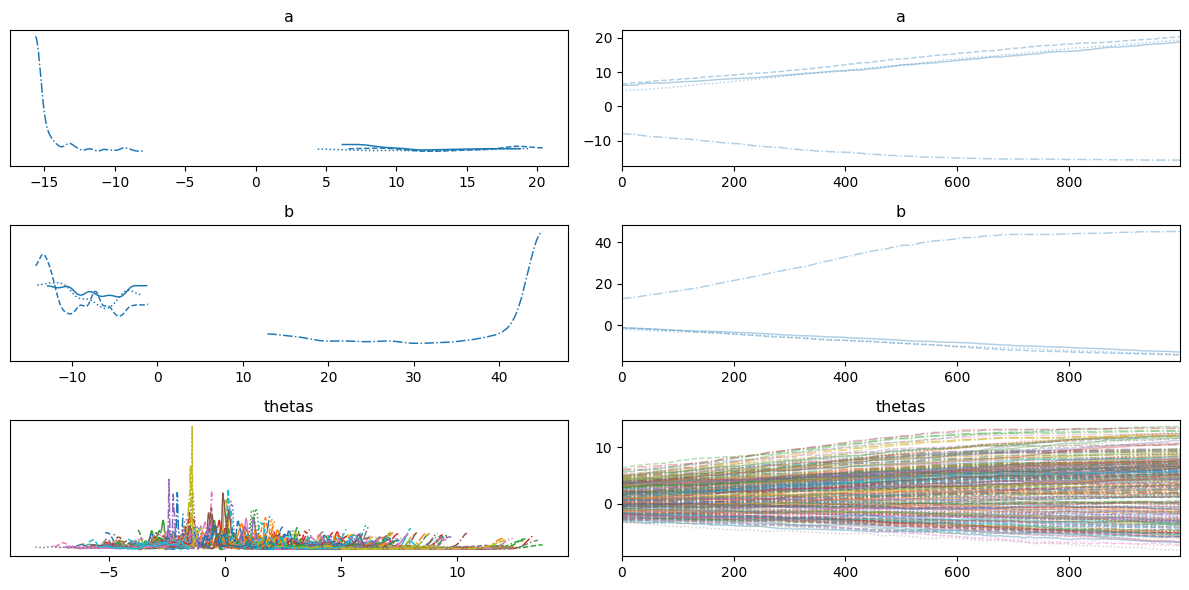

In [14]:
import matplotlib.pyplot as plt

az.plot_trace(trace)
plt.tight_layout()